# DataSet e bibliotecas a serem usados no projeto

In [546]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import jax as jax
from typing import Callable
from sklearn.model_selection import train_test_split
import time
import timeit
import matplotlib.pyplot as plt

# user id | item id | rating | timestamp.
_df = pd.read_csv('ml-100k/u.data', delimiter='\t', header=None, names=['userId', 'movieId', 'rating', 'timeStamp'])
originalData = _df.pivot(index='userId', columns='movieId', values='rating')
print("total elements: ", _df.count().sum())
print(_df.head(), "\n", "new df size: ", originalData.shape)


total elements:  400000
   userId  movieId  rating  timeStamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596 
 new df size:  (943, 1682)


### Separação de dados de teste

De acordo com a documentação, os dados já estão ordenados de maneira aleatória, então podemos apenas pegar os primeiros 20% de entradas.

In [547]:
testData = _df[:int(0.2*len(_df))]
_df = _df[int(0.2*len(_df)):]

# Tratamento dos dados: transposição em matriz, preenchimento de dados faltantes, normalização

In [548]:
# Convertendo a lista de dados em uma tabela com usuários nas linhas, filmes nas colunas, contendo os ratings correspondentes.
trainData = _df.pivot(index='userId', columns='movieId', values='rating')
testData = testData.pivot(index='userId', columns='movieId', values='rating')

# Reindexando os dataframes separados para incluuir todos os userIds e movieIds do dataframe original
userIds = [_ for _ in range(1, 944)]
movieIds = [_ for _ in range(1, 1683)]

trainData = trainData.reindex(index=userIds, columns=movieIds)
testData = testData.reindex(index=userIds, columns=movieIds)

# Preenchendo valores faltantes com o rating médio do filme correspondente
# trainData = trainData.apply(
#     lambda x: x.fillna(0) if x.isna().all() else x.fillna(x.mean(numeric_only=True)), axis=0)
trainData = trainData.fillna(0)
testData = testData.fillna(0)

trainData = jnp.array(trainData.values)
testData = jnp.array(testData.values)

print("Novo formato do DataFrame de treino: ", trainData.shape, "non zero elements: ", jnp.count_nonzero(trainData), '\n')
print("Novo formato do DataFrame de teste: ", testData.shape, "non zero elements: ", jnp.count_nonzero(testData), '\n')

Novo formato do DataFrame de treino:  (943, 1682) non zero elements:  80000 

Novo formato do DataFrame de teste:  (943, 1682) non zero elements:  20000 



In [504]:
def normalizeData(data:jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Normaliza dados de um array subtraindo médias normalizando em relação ao desvio padrão 
    de cada feature.

    Args:
        data (jnp.ndarray): Dados não normalizdos
        
    Returns:
        tuple[jnp.ndarray, jnp.ndarray]: Dados normalizados de treino e teste
    """

    # Normalizando os dados: subtração da média de cada feature e mapeando para o intervalo [0,1]
    mean = jnp.mean(data, axis=0)
    std = jnp.std(data, axis=0) + 1e-8

    data = data - mean
    data = data / std
    
    return data

In [549]:
# Normalizando os dados: subtração da média de cada feature e mapeando para o intervalo [0,1]
# Em alguns casos std era zero, e portanto um pequena constante é adicionada aos valroes para evitar divisão por zero
mean = jnp.mean(trainData, axis=0)
std = jnp.std(trainData, axis=0) + 1e-8

normalizedTrainData = trainData - mean
# normalizedTrainData = normalizedTrainData / std

# normalizedTestData = testData - mean
# normalizedTestData = normalizedTestData / std

# Normalizando os dados. 
# trainData = normalizeData(jnp.array(trainData.values))
# print(testData.shape)


# Definindo as funções para implementação do SVD, KNN e PCA

In [550]:
def reorder(eigenvalues:jnp.ndarray, eigenvectors:jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """ Reorders in descending order the eigenvalues and corresponding eigenvectors based on the eigenvectors values.

    Args:
        eigenvalues (jnp.ndarray): 1D array containing the eigenvalues.
        eigenvectors (jnp.ndarray): 2D array cotaining eigenvectors as columns.

    Returns:
        tuple[jnp.ndarray, jnp.ndarray]: Reordered eigenvalues and eigenvectors.
    """
    orderedIndices = jnp.argsort(eigenvalues, descending=True) 
    orderedEigenvalues = eigenvalues[orderedIndices] 
    orderedEigenvectors = eigenvectors[:, orderedIndices] 

    return orderedEigenvalues, orderedEigenvectors


def svd(data:jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """ From a data matrix, return its Singular Value Decomposition (SVD) 
    computed using the eigendecomposition of the data's covariance matrix.

    Args:
        data (jnp.ndarray): Rectangular matrix

    Returns:
        tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]: SVD of the data matrix, where data = U.S.V^T
    """

    # Computing the data matrix's right-singular vectors, as well as the singular values
    eigenvalues, rEigenvectors = jnp.linalg.eig(data.T @ data)
    eigenvalues, rEigenvectors = reorder(eigenvalues, rEigenvectors)
    Vt = jnp.real(rEigenvectors.T)    
    S = jnp.real(eigenvalues ** (1/2))

    # Computing the data matrix's left-singular vectors
    eigenvalues, lEigenvectors = jnp.linalg.eig(data @ data.T)
    eigenvalues, lEigenvectors = reorder(eigenvalues, lEigenvectors)
    U = jnp.real(lEigenvectors)

    
    return U, S, Vt

In [551]:
def pca(data:jnp.ndarray, nbComponents:int, svd=True) -> jnp.ndarray:
    """
    A partir de um conjunto de dados, retorna a matriz de projeção para as k componentes principais.

    Args:
        data (jnp.ndaaray): Dados para reduzir dimensionalidade.
        nbComponents (int): Número de componentes desejadas na projeção.

    Returns:
        jnp.ndarray: Matriz de projeção.
    """

    covarianceMatrix = (1/len(data)) * data.T @ data
    
    if svd:
        # Realizando a decomposição em valores singulares. U terá vetores coluna ortogonais.  
        # A pricípio, o ordenamento não é necessário pois svd() já retorna os valores singulares ordenados.  
        U, S, Ut = jax.scipy.linalg.svd(covarianceMatrix) 
        projectionMatrix = U[:, :nbComponents]
    else:
        # Decomposição a partir de autovalores e autovetores.
        # Aqui, o ordenamento dos autovetores baseado nos autovalores é necessário.
        eigenvalues, eigenvectors = jnp.linalg.eig(covarianceMatrix)  
        indices = jnp.argsort(eigenvalues, descending=True)           
        projectionMatrix = eigenvectors[:, indices]  
        projectionMatrix = projectionMatrix[:, :nbComponents]
   

    return projectionMatrix

In [552]:
def knn(xTrain:jnp.ndarray, yTrain:jnp.ndarray, xTest:jnp.ndarray, k:int, metric:Callable[[jnp.ndarray, jnp.ndarray], float]) -> jnp.ndarray:
    """ Implementa a classificação de um conjunto de dados a partir do algoritmo de K-Nearest Neighbors (KNN).

    Args:
        xTrain (jnp.ndarray): Dados de treino
        yTrain (jnp.ndarray): Labels para os dados de treino
        xTest (jnp.ndarray): Dados de teste
        k (int): Número de vizinhos mais próximos usados para a classificação.
        metric (Callable): Função que calcula distância entre dois pontos.

    Returns:
        jnp.ndarray: Array contendo as predições realizadas para o conjunto de dados de teste xTest.
    """
    
    # Implementação JAX-friendly do cálculo da matriz de distâncias para um conjunto de pontos de teste.
    # O cálculo da matriz é feito vetorizando duas vezes a função de métrica, para calcular dois a dois
    # as distâncias entre pontos de treino e de teste.
    distances = jax.vmap(lambda train_point: jax.vmap(metric, in_axes=(None, 0))(train_point, xTest))(xTrain)

    # Ordenando as distâncias entre pontos, e pegando os targets/labels dos k pontos mais próximos para cada ponto de treino
    sorted_indices = jnp.argsort(distances, axis=0)
    nearestNeighborsIndices = sorted_indices[:k, :]
    nearestNeighbors = yTrain[nearestNeighborsIndices].astype(int)

    # Contagem dos números de cada target presente na lista de vizinhos próximos e definição do target estimado para o ponto
    # de teste baseado numa voto de maioria.
    totalLabels = 3
    targetCounts = jax.vmap(lambda neighbors: jnp.bincount(neighbors, minlength=totalLabels, length=3))(nearestNeighbors.T) 
    most_common_classes = jnp.argmax(targetCounts, axis=1)
    
    return most_common_classes

In [597]:
nbComponents = 5
# Realizando a decomposição em valores singulares. U terá vetores coluna ortogonais.  
# A pricípio, o ordenamento não é necessário pois svd() já retorna os valores singulares ordenados.  
# U, S, Vt = svd(trainData) 
U, S, Vt = jax.scipy.linalg.svd(normalizedTrainData) 

print(U.shape, S.shape, Vt.shape)

zeroColumns = Vt.shape[0] - U.shape[0]
zeroRows = U.shape[1]
_zeros = jnp.zeros((zeroRows, zeroColumns))

Sdiag = jnp.hstack([jnp.diag(S), _zeros])

(943, 943) (943,) (1682, 1682)


In [598]:
UTrunk = U[:, :nbComponents]
VtTrunk = Vt[:nbComponents, :]
SdiagTrunk = Sdiag[:nbComponents, :nbComponents]

print(UTrunk.shape, SdiagTrunk.shape, VtTrunk.shape)

approximateData = UTrunk @ SdiagTrunk @ VtTrunk

approximateData = approximateData + mean
approximateData

(943, 5) (5, 5) (5, 1682)


Array([[ 2.5486565e+00,  5.6937754e-01,  5.9973741e-01, ...,
        -8.2353456e-03,  9.4248550e-03,  1.9595688e-02],
       [ 1.6488464e+00, -3.7914988e-01,  2.8829008e-01, ...,
         5.4324009e-03, -5.2203778e-03, -3.6274111e-03],
       [ 1.5708733e-01,  2.5339991e-02, -5.4700911e-02, ...,
         1.1859557e-02, -2.8001890e-03, -4.4340994e-03],
       ...,
       [ 1.8385912e+00,  1.0563821e-02,  2.5117537e-01, ...,
        -5.0323429e-03, -3.3845934e-03,  1.5271723e-03],
       [ 6.2362760e-01,  3.0027136e-01, -1.9340703e-01, ...,
         1.4878384e-02,  2.6372129e-03, -1.1608724e-02],
       [ 3.2532268e+00,  1.8603065e+00,  9.0886402e-01, ...,
        -8.5140169e-03,  2.2198109e-02,  2.7645901e-02]], dtype=float32)

In [599]:
normalizedTrainData + mean

Array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]], dtype=float32)

In [603]:
testDataMask = jnp.where(testData != 0, 1, 0)
filteredApproximateData = approximateData * testDataMask

filteredApproximateData

17226.008


Array([[ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0., -0., -0.],
       [ 0.,  0., -0., ...,  0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ..., -0., -0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ..., -0.,  0.,  0.]], dtype=float32)

In [601]:
diff = jnp.abs(filteredApproximateData - testData)
jnp.sum(diff)/20000

Array(2.6862917, dtype=float32)

In [580]:
print("non zero elements: ", jnp.count_nonzero(filteredApproximateData), '\n')
print("non zero elements: ", jnp.count_nonzero(testData), '\n')

print(testData.sum())
print(filteredApproximateData.sum())

non zero elements:  19968 

non zero elements:  20000 

70718.0
18137.268


In [611]:
dS = S[:-1] - S[1:]


In [613]:
for i in range(100):
    print(S[i], dS[i])

366.80048 176.23427
190.56621 25.467758
165.09845 29.207016
135.89143 5.4171295
130.4743 13.453194
117.02111 11.661018
105.36009 2.0714798
103.28861 10.310013
92.9786 8.7643585
84.21424 1.9773483
82.23689 2.8237839
79.41311 1.7454834
77.667625 1.516304
76.15132 0.56607056
75.58525 1.0454102
74.53984 1.552681
72.98716 1.5230179
71.46414 0.736763
70.72738 1.2323914
69.49499 1.3812943
68.11369 0.96349335
67.1502 0.5355911
66.61461 0.11553192
66.49908 1.0952225
65.403854 0.2671051
65.13675 0.38715363
64.749596 0.7793274
63.97027 0.576519
63.39375 0.47681808
62.91693 0.17673874
62.740192 0.38425064
62.35594 0.13376617
62.222176 0.624424
61.59775 0.151371
61.44638 0.41368484
61.032696 0.19026947
60.842426 0.20096588
60.64146 0.36404037
60.27742 0.40502548
59.872395 0.079898834
59.792496 0.47359848
59.318897 0.2869835
59.031914 0.19615555
58.83576 0.4325714
58.403187 0.30275726
58.10043 0.2582779
57.84215 0.23952866
57.602623 0.21126938
57.391354 0.22853088
57.162823 0.5956688
56.567154 0.311

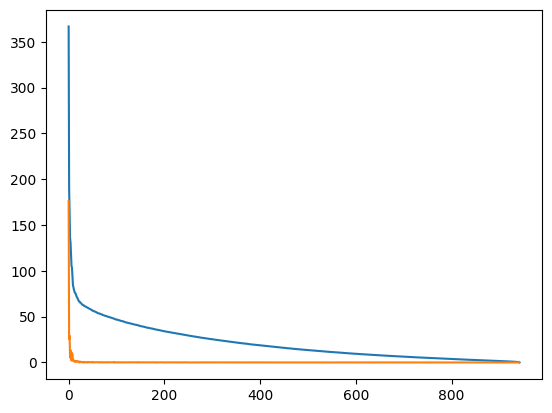

In [610]:
plt.plot(range(0, len(S)), S)
plt.plot(range(len(dS)), dS)

# Testando a implementação da decomposição em valores principais a partir dos autovalores e autovetores da matriz de covariância dos dados.

Aqui geramos uma matriz aleatória, calculamos seus valores e vetores principais, e comparamos com a implementação nativa do JAX para fins de checagem de sanidade. 

Vemos que a matrix ortogonal de vetores principais não é a mesma obtida pela implementação do JAX, porém isso acontece somente devido a uma inversão do sinal de alguns dos vetores. Nas matrizes U e Ut, isso se traduz respectivamente em uma inversão de sinal de colunas ou linhas especificas, o que não altera as propriedades matemáticas da nossa decomposição. Portanto, a menos de desvios numéricos, temos uma implementação equivalente feita a partir dos autovetores e autovalores da matriz de dados. 

In [43]:
# Gerando os dados aleatórios para teste
key = jax.random.PRNGKey(0)
random_array = jax.random.uniform(key, (5, 4))
data = random_array
covarianceMatrix = (1/len(data)) * data.T @ data

# Calculando a SVD usando dois métodos diferentes: implementação nativa e usando autovalores e autovetores
U1, S1, Vt1 = jax.scipy.linalg.svd(covarianceMatrix) 
U2, S2, Vt2 = svd(covarianceMatrix) 

In [44]:
# Os dois arrays devem ser iguais, a menos de um sinal em cada coluna
print("Comparando U: ")
print(U1)
print(U2)

# Os dois arrays devem ser iguais, a menos de um sinal em cada linha
print("\n\nComparando Ut: ")
print(Vt1)
print(Vt2)

# Os valores principais devem ser exatamente iguais
print("\n\nComparando valores principais: ")
print(S1)
print(S2)

Comparando U: 
[[-0.5625489   0.7061049  -0.26226145 -0.34084198]
 [-0.45437548 -0.49096245  0.43556333 -0.60231495]
 [-0.4274326  -0.50450015 -0.71912175  0.21364647]
 [-0.5425707   0.07649231  0.47367406  0.6894916 ]]
[[ 0.56254894 -0.70610535  0.26226294  0.34084186]
 [ 0.4543755   0.4909616  -0.43556163  0.6023146 ]
 [ 0.42743263  0.5045007   0.71912086 -0.21364544]
 [ 0.54257077 -0.07649165 -0.4736765  -0.6894922 ]]


Comparando Ut: 
[[-0.56254894 -0.4543754  -0.4274326  -0.5425706 ]
 [ 0.706105   -0.49096242 -0.50450003  0.07649231]
 [-0.26226142  0.43556345 -0.719122    0.47367418]
 [-0.340842   -0.60231483  0.21364635  0.6894918 ]]
[[ 0.56254894  0.4543755   0.42743257  0.5425707 ]
 [-0.7061053   0.49096262  0.5044998  -0.07649182]
 [ 0.26226133 -0.435565    0.7191219  -0.47367254]
 [ 0.3408419   0.60231435 -0.21364391 -0.689493  ]]


Comparando valores principais: 
[1.2094074  0.1760837  0.10692322 0.05494076]
[1.2094078  0.17608385 0.10692321 0.05494073]
